##### Copyright 2020 The TensorFlow Authors.

In [5]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [6]:
!pip install tensorflow==2.7.0

  Obtaining dependency information for protobuf>=3.9.2 from https://files.pythonhosted.org/packages/ae/5b/7ed02a9b8e752c8f7bca8661779c0275b9e3e6a903a3045e6da51f796dda/protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata
  Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)


  Obtaining dependency information for google-auth<3,>=1.6.3 from https://files.pythonhosted.org/packages/f4/d2/9f6f3b9c0fd486617816cff42e856afea079d0bad99f0e60dc186c76b881/google_auth-2.25.2-py2.py3-none-any.whl.metadata
  Using cached google_auth-2.25.2-py2.py3-none-any.whl.metadata (4.7 kB)
Using cached protobuf-4.25.1-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached google_auth-2.25.2-py2.py3-none-any.whl (184 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.18.0
    Uninstalling google-auth-1.18.0:
      Successfully uninstalled google-auth-1.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.21.0 requires google-auth<2.0dev,>=1.18

Install TensorFlow Quantum:

In [7]:
!pip install tensorflow-quantum==0.7.2

  Using cached google_auth-1.18.0-py2.py3-none-any.whl (90 kB)
  Using cached protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.1
    Uninstalling protobuf-4.25.1:
      Successfully uninstalled protobuf-4.25.1
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.25.2
    Uninstalling google-auth-2.25.2:
      Successfully uninstalled google-auth-2.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-auth-oauthlib 1.0.0 requires google-auth>=2.15.0, but you have google-auth 1.18.0 which is incompatible.
tensorboard 2.14.0 requires protobuf>=3.19.6, but you have protobuf 3.17.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/henrique/Documentos/quantum/.venv/lib/python3.8/site-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [10]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [12]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [13]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


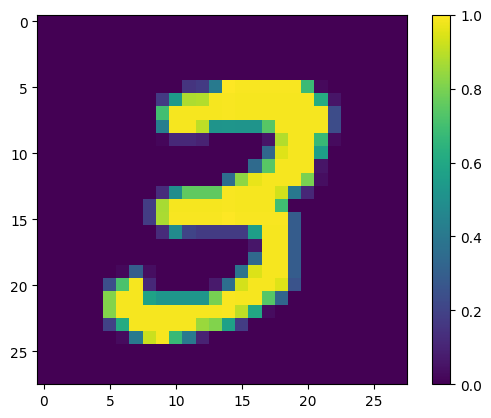

In [14]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [15]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [16]:
print(x_train_small.shape)

(12049, 4, 4, 1)


Again, display the first training example—after resize: 

True


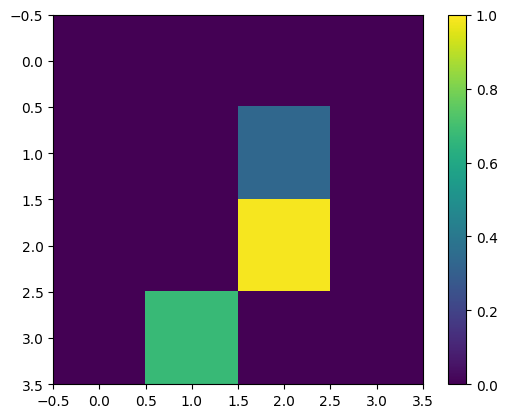

In [17]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [18]:
def remove_contradicting(xs, ys):
    return xs, ys
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [19]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [20]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [21]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [22]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


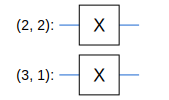

In [23]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [24]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [25]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [26]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


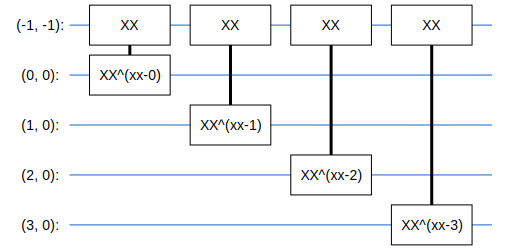

In [27]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [28]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [29]:
model_circuit, model_readout = create_quantum_model()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [30]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [31]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [32]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [33]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [34]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [35]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [36]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [37]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


377/377 [==============================] - 416s 1s/step - loss: 0.6174 - hinge_accuracy: 0.7536 - val_loss: 0.3986 - val_hinge_accuracy: 0.7999
Epoch 2/3
377/377 [==============================] - 404s 1s/step - loss: 0.3807 - hinge_accuracy: 0.8110 - val_loss: 0.3484 - val_hinge_accuracy: 0.8281
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3238 - hinge_accuracy: 0.8488


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

## 3. Teste de Filtros - MNIST

Esta é a parte original do trabalho, em que vários filtros são testados e aplicados para descobrirmos qual o melhor filtro para o problema.

> Vale notar que o filtro pode ser dependente do tipo de classificador que está sendo utilizado, neste caso estamos descobrindo qual melhor classificador para o problema baseado no modelo do artigo "Rede Neural Utilizada".

In [38]:
def process_data(x_train, x_test, y_train, y_test, method, antialias=False):
    # sobel fiter resize
    x_train_resized = tf.image.resize(x_train, (4,4), method=method, antialias=antialias).numpy()
    x_test_resized = tf.image.resize(x_test, (4,4), method=method, antialias=antialias).numpy()

    print(y_train[0])

    if len(x_train_resized.shape) == 4:
      plt.imshow(x_train_resized[0,:,:,0], vmin=0, vmax=1)
      plt.colorbar()
    else:
      plt.imshow(x_train_resized[0,:,:], vmin=0, vmax=1)

    # Retirar contraditórios - igual no artigo base e no código do Google

    # x_train_resized, y_train_resized = remove_contradicting(x_train_resized, y_train)
    x_train_resized, y_train_resized = x_train_resized, y_train

    # binarizar

    THRESHOLD = 0.5

    x_train_bin = np.array(x_train_resized > THRESHOLD, dtype=np.float32)
    x_test_bin = np.array(x_test_resized > THRESHOLD, dtype=np.float32)

    x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
    x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

    # converter para tensor

    x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
    x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

    # Otimizar Hinge Loss

    y_train_hinge = 2.0*y_train_resized-1.0
    y_test_hinge = 2.0*y_test-1.0

    # Treinar o modelo

    EPOCHS = 3
    BATCH_SIZE = 32

    NUM_EXAMPLES = len(x_train_tfcirc)

    x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
    y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

    qnn_history_resized = model.fit(
          x_train_tfcirc_sub, y_train_hinge_sub,
          batch_size=32,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_test_tfcirc, y_test_hinge))

    qnn_results_resized = model.evaluate(x_test_tfcirc, y_test)
    
    return qnn_results_resized

### 3.1 Filtro de interpolação bilinear

True
Epoch 1/3
377/377 [==============================] - 396s 1s/step - loss: 0.3311 - hinge_accuracy: 0.8508 - val_loss: 0.3239 - val_hinge_accuracy: 0.8503
Epoch 2/3
377/377 [==============================] - 397s 1s/step - loss: 0.3305 - hinge_accuracy: 0.8526 - val_loss: 0.3238 - val_hinge_accuracy: 0.8503
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3219 - hinge_accuracy: 0.8523


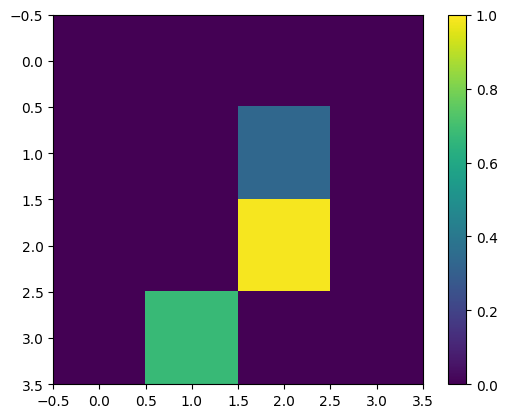

In [39]:
qnn_results_bilinear = process_data(x_train, x_test, y_train, y_test, 'bilinear')

### 3.2 Filtro de Hat/Tent

True
Epoch 1/3
377/377 [==============================] - 392s 1s/step - loss: 0.6928 - hinge_accuracy: 0.6548 - val_loss: 0.6559 - val_hinge_accuracy: 0.6658
Epoch 2/3
377/377 [==============================] - 391s 1s/step - loss: 0.6874 - hinge_accuracy: 0.6547 - val_loss: 0.6540 - val_hinge_accuracy: 0.6658
Epoch 3/3
62/62 [==============================] - 4s 66ms/step - loss: 0.6537 - hinge_accuracy: 0.6658


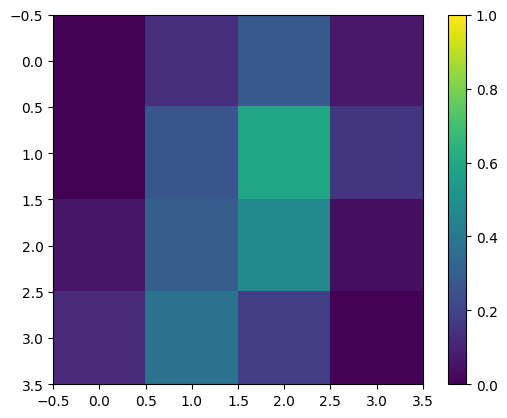

In [40]:
qnn_results_hat_tent = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

True
Epoch 1/3
377/377 [==============================] - 397s 1s/step - loss: 0.3357 - hinge_accuracy: 0.8439 - val_loss: 0.3214 - val_hinge_accuracy: 0.8553
Epoch 2/3
377/377 [==============================] - 396s 1s/step - loss: 0.3279 - hinge_accuracy: 0.8566 - val_loss: 0.3220 - val_hinge_accuracy: 0.8553
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3215 - hinge_accuracy: 0.8564


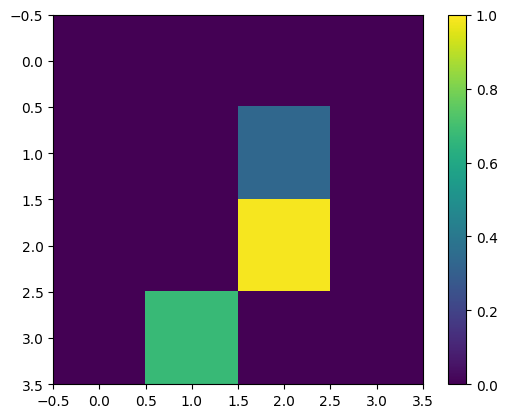

In [41]:
# sobel fiter resize
x_train_lanczos3 = tf.image.resize(x_train, (4,4), method='lanczos3').numpy()
x_test_lanczos3 = tf.image.resize(x_test, (4,4), method='lanczos3').numpy()

print(y_train[0])

plt.imshow(x_train_lanczos3[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_lanczos3, y_train_lanczos3 = remove_contradicting(x_train_lanczos3, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_lanczos3 > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_lanczos3 > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_lanczos3-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_lanczos3 = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_lanczos3 = model.evaluate(x_test_tfcirc, y_test)

### Filtro lanczos5

True
Epoch 1/3
377/377 [==============================] - 397s 1s/step - loss: 0.3275 - hinge_accuracy: 0.8545 - val_loss: 0.3209 - val_hinge_accuracy: 0.8614
Epoch 2/3
377/377 [==============================] - 397s 1s/step - loss: 0.3275 - hinge_accuracy: 0.8562 - val_loss: 0.3218 - val_hinge_accuracy: 0.8614
Epoch 3/3
62/62 [==============================] - 4s 66ms/step - loss: 0.3205 - hinge_accuracy: 0.8614


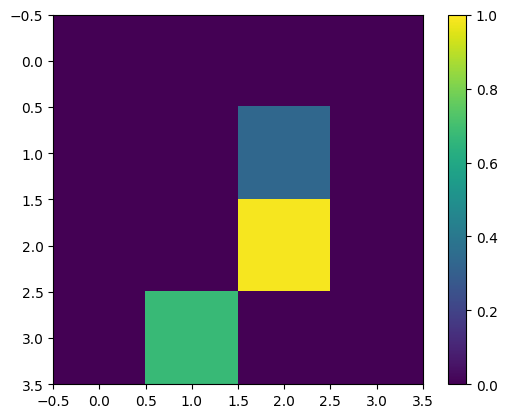

In [42]:
# sobel fiter resize
x_train_lanczos5 = tf.image.resize(x_train, (4,4), method='lanczos5').numpy()
x_test_lanczos5 = tf.image.resize(x_test, (4,4), method='lanczos5').numpy()

print(y_train[0])

plt.imshow(x_train_lanczos5[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_lanczos5, y_train_lanczos5 = remove_contradicting(x_train_lanczos5, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_lanczos5 > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_lanczos5 > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_lanczos5-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_lanczos5 = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_lanczos5 = model.evaluate(x_test_tfcirc, y_test)

### Filtro bicubic

True
Epoch 1/3
377/377 [==============================] - 397s 1s/step - loss: 0.3275 - hinge_accuracy: 0.8572 - val_loss: 0.3206 - val_hinge_accuracy: 0.8614
Epoch 2/3
377/377 [==============================] - 397s 1s/step - loss: 0.3272 - hinge_accuracy: 0.8597 - val_loss: 0.3233 - val_hinge_accuracy: 0.8569
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3194 - hinge_accuracy: 0.8614


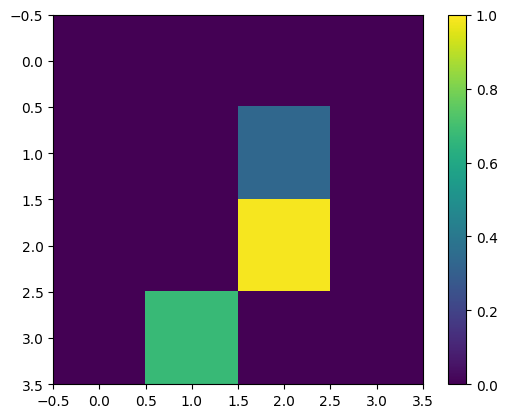

In [43]:
# sobel fiter resize
x_train_bicubic = tf.image.resize(x_train, (4,4), method='bicubic').numpy()
x_test_bicubic = tf.image.resize(x_test, (4,4), method='bicubic').numpy()

print(y_train[0])

plt.imshow(x_train_bicubic[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_bicubic, y_train_bicubic = remove_contradicting(x_train_bicubic, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_bicubic > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_bicubic > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_bicubic-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_bicubic = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_bicubic = model.evaluate(x_test_tfcirc, y_test)

### Filtro gaussian

True
Epoch 1/3
377/377 [==============================] - 396s 1s/step - loss: 0.3193 - hinge_accuracy: 0.8589 - val_loss: 0.3088 - val_hinge_accuracy: 0.8629
Epoch 2/3
377/377 [==============================] - 396s 1s/step - loss: 0.3189 - hinge_accuracy: 0.8565 - val_loss: 0.3090 - val_hinge_accuracy: 0.8664
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3110 - hinge_accuracy: 0.8619


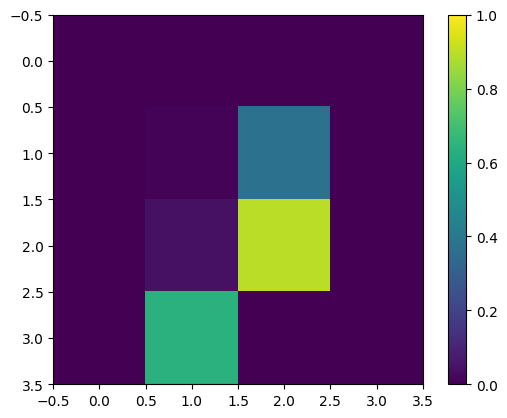

In [44]:
# sobel fiter resize
x_train_gaussian = tf.image.resize(x_train, (4,4), method='gaussian').numpy()
x_test_gaussian = tf.image.resize(x_test, (4,4), method='gaussian').numpy()

print(y_train[0])

plt.imshow(x_train_gaussian[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_gaussian, y_train_gaussian = remove_contradicting(x_train_gaussian, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_gaussian > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_gaussian > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_gaussian-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_gaussian = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_gaussian = model.evaluate(x_test_tfcirc, y_test)

### Filtro nearest

True
Epoch 1/3
377/377 [==============================] - 397s 1s/step - loss: 0.3268 - hinge_accuracy: 0.8549 - val_loss: 0.3200 - val_hinge_accuracy: 0.8614
Epoch 2/3
377/377 [==============================] - 397s 1s/step - loss: 0.3266 - hinge_accuracy: 0.8563 - val_loss: 0.3200 - val_hinge_accuracy: 0.8614
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.3226 - hinge_accuracy: 0.8599


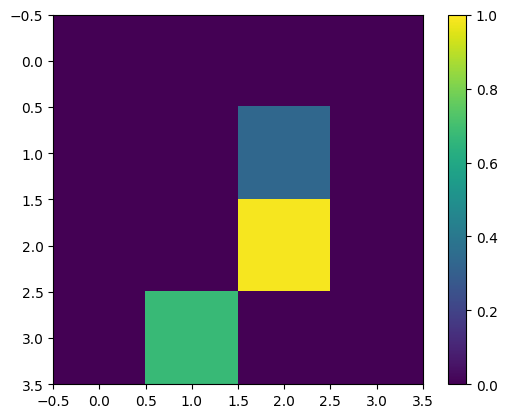

In [45]:
# sobel fiter resize
x_train_nearest = tf.image.resize(x_train, (4,4), method='nearest').numpy()
x_test_nearest = tf.image.resize(x_test, (4,4), method='nearest').numpy()

print(y_train[0])

plt.imshow(x_train_nearest[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_nearest, y_train_nearest = remove_contradicting(x_train_nearest, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_nearest > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_nearest > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_nearest-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_nearest = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_nearest = model.evaluate(x_test_tfcirc, y_test)

### Filtro area

True
Epoch 1/3
377/377 [==============================] - 393s 1s/step - loss: 0.4760 - hinge_accuracy: 0.7662 - val_loss: 0.4563 - val_hinge_accuracy: 0.7702
Epoch 2/3
377/377 [==============================] - 393s 1s/step - loss: 0.4692 - hinge_accuracy: 0.7662 - val_loss: 0.4581 - val_hinge_accuracy: 0.7702
Epoch 3/3
62/62 [==============================] - 4s 67ms/step - loss: 0.4572 - hinge_accuracy: 0.7702


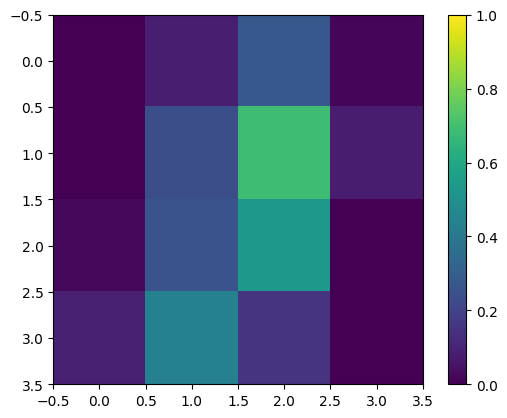

In [46]:
# sobel fiter resize
x_train_area = tf.image.resize(x_train, (4,4), method='area').numpy()
x_test_area = tf.image.resize(x_test, (4,4), method='area').numpy()

print(y_train[0])

plt.imshow(x_train_area[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_area, y_train_area = remove_contradicting(x_train_area, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_area > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_area > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_area-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_area = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_area = model.evaluate(x_test_tfcirc, y_test)

### Filtro mitchellcubic

True
Epoch 1/3
377/377 [==============================] - 396s 1s/step - loss: 0.3285 - hinge_accuracy: 0.8414 - val_loss: 0.3133 - val_hinge_accuracy: 0.8558
Epoch 2/3
377/377 [==============================] - 396s 1s/step - loss: 0.3235 - hinge_accuracy: 0.8533 - val_loss: 0.3123 - val_hinge_accuracy: 0.8594
Epoch 3/3
62/62 [==============================] - 4s 66ms/step - loss: 0.3125 - hinge_accuracy: 0.8594


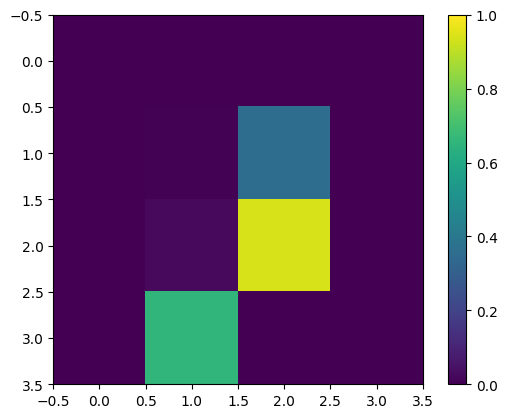

In [47]:
# sobel fiter resize
x_train_mitchellcubic = tf.image.resize(x_train, (4,4), method='mitchellcubic').numpy()
x_test_mitchellcubic = tf.image.resize(x_test, (4,4), method='mitchellcubic').numpy()

print(y_train[0])

plt.imshow(x_train_mitchellcubic[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_mitchellcubic, y_train_mitchellcubic = remove_contradicting(x_train_mitchellcubic, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_mitchellcubic > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_mitchellcubic > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_mitchellcubic-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_mitchellcubic = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_mitchellcubic = model.evaluate(x_test_tfcirc, y_test)

## Comparação dos filtros

/tmp/ipykernel_6169/1215795459.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


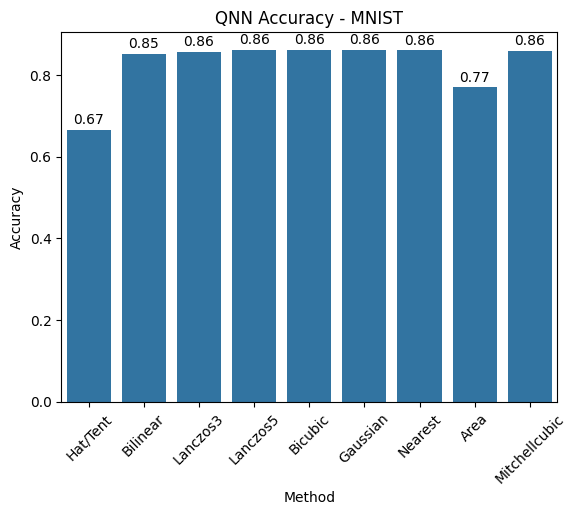

In [48]:
qnn_accuracy_hat_tent = qnn_results_hat_tent[1]
qnn_accuracy_bilinear = qnn_results_bilinear[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5[1]
qnn_accuracy_bicubic = qnn_results_bicubic[1]
qnn_accuracy_gaussian = qnn_results_gaussian[1]
qnn_accuracy_nearest = qnn_results_nearest[1]
qnn_accuracy_area = qnn_results_area[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic[1]


ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
                 y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - MNIST')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()


# Comparação de Filtros - CIFAR-10

2023-12-19 11:13:27.142134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2023-12-19 11:13:27.433811: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Number of original training examples: 50000
Number of original test examples: 10000
Shape of x_train: (10000, 32, 32, 1)


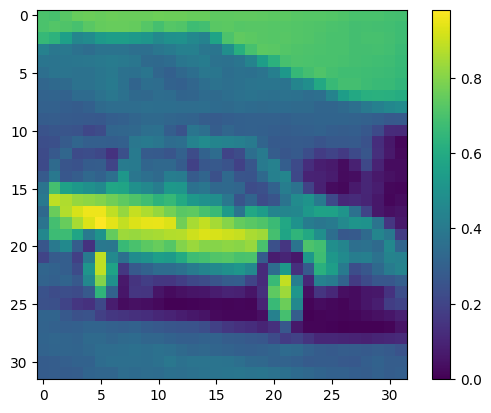

In [49]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

## Filtro de interpolação bilinear

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.9614 - hinge_accuracy: 0.5266 - val_loss: 0.9420 - val_hinge_accuracy: 0.5536
Epoch 2/3
313/313 [==============================] - 350s 1s/step - loss: 0.9141 - hinge_accuracy: 0.5535 - val_loss: 0.9119 - val_hinge_accuracy: 0.5580
Epoch 3/3
63/63 [==============================] - 4s 70ms/step - loss: 0.8867 - hinge_accuracy: 0.5645


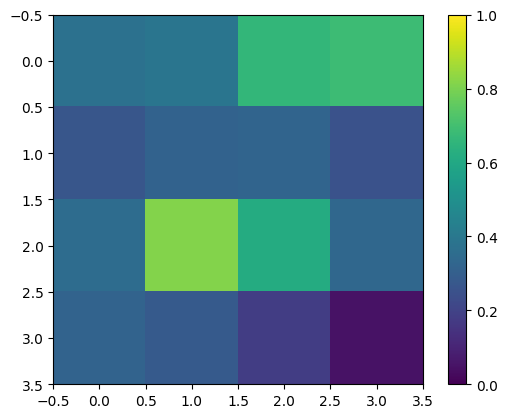

In [50]:
qnn_results_bilinear_cifar = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[1]
Epoch 1/3
313/313 [==============================] - 349s 1s/step - loss: 0.8563 - hinge_accuracy: 0.5763 - val_loss: 0.8498 - val_hinge_accuracy: 0.5838
Epoch 2/3
313/313 [==============================] - 349s 1s/step - loss: 0.8409 - hinge_accuracy: 0.5804 - val_loss: 0.8446 - val_hinge_accuracy: 0.5838
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.8428 - hinge_accuracy: 0.5828


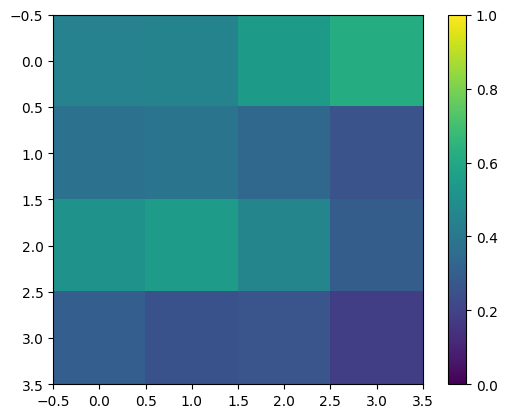

In [51]:
qnn_results_hat_tent_cifar = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.8518 - hinge_accuracy: 0.5754 - val_loss: 0.8615 - val_hinge_accuracy: 0.5769
Epoch 2/3
313/313 [==============================] - 349s 1s/step - loss: 0.8468 - hinge_accuracy: 0.5795 - val_loss: 0.8602 - val_hinge_accuracy: 0.5769
Epoch 3/3
63/63 [==============================] - 4s 70ms/step - loss: 0.8601 - hinge_accuracy: 0.5779


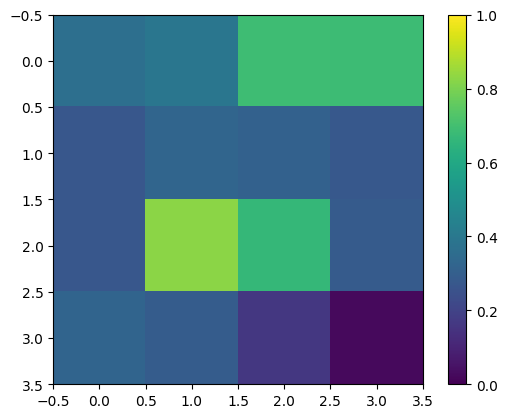

In [52]:
qnn_results_lanczos3_cifar = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.8469 - hinge_accuracy: 0.5764 - val_loss: 0.8583 - val_hinge_accuracy: 0.5774
Epoch 2/3
313/313 [==============================] - 350s 1s/step - loss: 0.8459 - hinge_accuracy: 0.5778 - val_loss: 0.8586 - val_hinge_accuracy: 0.5759
Epoch 3/3
63/63 [==============================] - 5s 77ms/step - loss: 0.8580 - hinge_accuracy: 0.5754


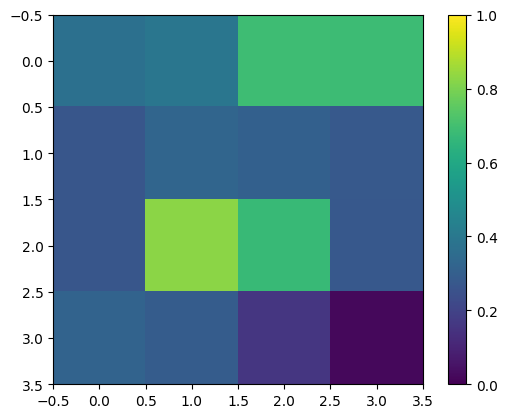

In [53]:
qnn_results_lanczos5_cifar = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[1]
Epoch 1/3
313/313 [==============================] - 364s 1s/step - loss: 0.8402 - hinge_accuracy: 0.5810 - val_loss: 0.8680 - val_hinge_accuracy: 0.5655
Epoch 2/3
313/313 [==============================] - 352s 1s/step - loss: 0.8391 - hinge_accuracy: 0.5805 - val_loss: 0.8675 - val_hinge_accuracy: 0.5704
Epoch 3/3
63/63 [==============================] - 4s 70ms/step - loss: 0.8669 - hinge_accuracy: 0.5729


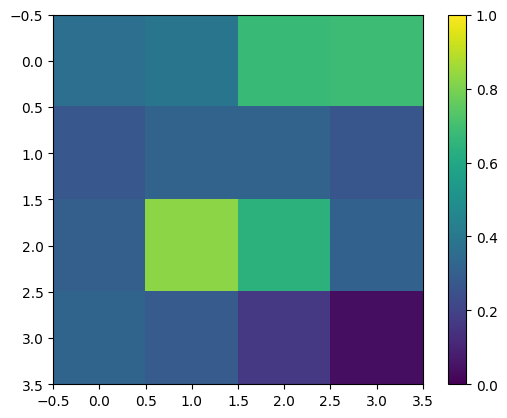

In [54]:
qnn_results_bicubic_cifar = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.8343 - hinge_accuracy: 0.5851 - val_loss: 0.8557 - val_hinge_accuracy: 0.5769
Epoch 2/3
313/313 [==============================] - 350s 1s/step - loss: 0.8338 - hinge_accuracy: 0.5871 - val_loss: 0.8556 - val_hinge_accuracy: 0.5754
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.8554 - hinge_accuracy: 0.5759


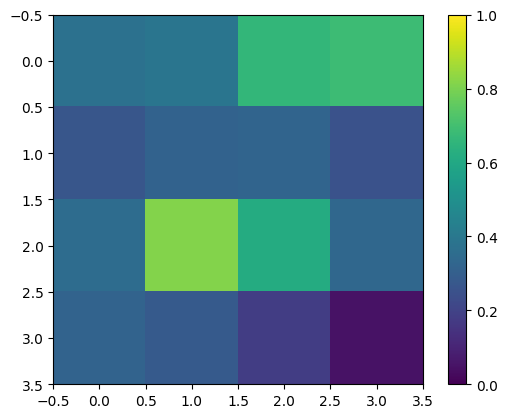

In [55]:
qnn_results_gaussian_cifar = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.8377 - hinge_accuracy: 0.5853 - val_loss: 0.8665 - val_hinge_accuracy: 0.5714
Epoch 2/3
313/313 [==============================] - 357s 1s/step - loss: 0.8365 - hinge_accuracy: 0.5876 - val_loss: 0.8626 - val_hinge_accuracy: 0.5744
Epoch 3/3
63/63 [==============================] - 5s 77ms/step - loss: 0.8614 - hinge_accuracy: 0.5764


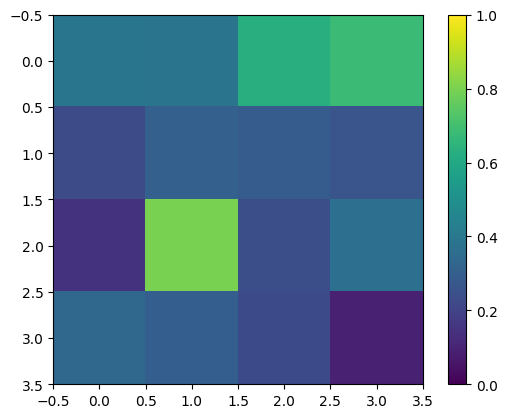

In [56]:
qnn_results_nearest_cifar = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[1]
Epoch 1/3
313/313 [==============================] - 350s 1s/step - loss: 0.8465 - hinge_accuracy: 0.5779 - val_loss: 0.8512 - val_hinge_accuracy: 0.5809
Epoch 2/3
313/313 [==============================] - 350s 1s/step - loss: 0.8431 - hinge_accuracy: 0.5768 - val_loss: 0.8524 - val_hinge_accuracy: 0.5764
Epoch 3/3
63/63 [==============================] - 4s 70ms/step - loss: 0.8533 - hinge_accuracy: 0.5764


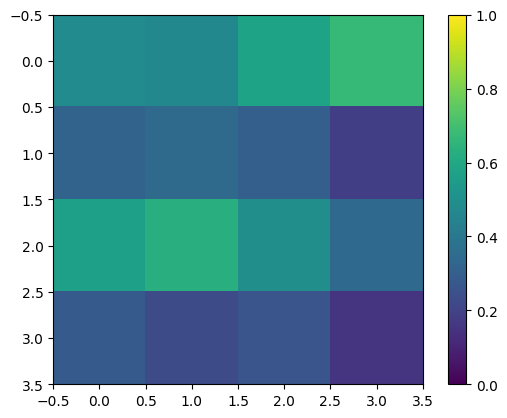

In [57]:
qnn_results_area_cifar = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[1]
Epoch 1/3
313/313 [==============================] - 349s 1s/step - loss: 0.8383 - hinge_accuracy: 0.5802 - val_loss: 0.8655 - val_hinge_accuracy: 0.5709
Epoch 2/3
313/313 [==============================] - 350s 1s/step - loss: 0.8365 - hinge_accuracy: 0.5813 - val_loss: 0.8640 - val_hinge_accuracy: 0.5724
Epoch 3/3
63/63 [==============================] - 4s 70ms/step - loss: 0.8634 - hinge_accuracy: 0.5744


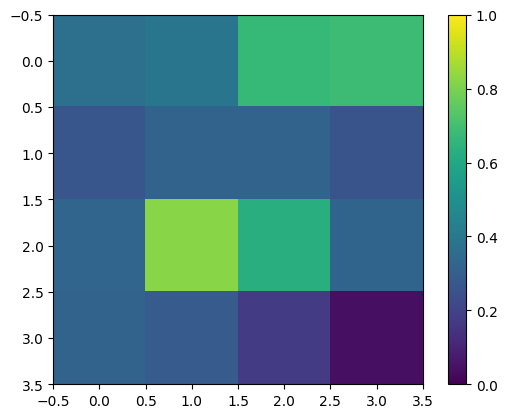

In [58]:
qnn_results_mitchellcubic_cifar = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6169/1064917995.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


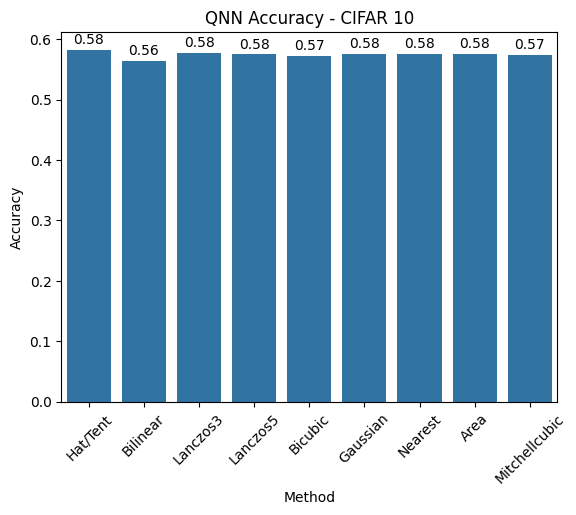

In [59]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar[1]
qnn_accuracy_area = qnn_results_area_cifar[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 10')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros Fashion MNIST

Number of original training examples: 60000
Number of original test examples: 10000


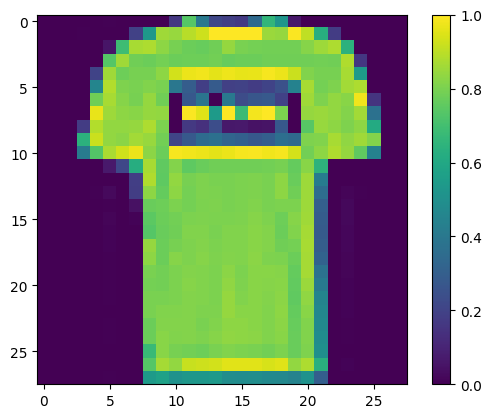

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

class1 = 0  # Desired class 1
class2 = 1  # Desired class 2

# Define the desired classes for filtering
classes_desejadas = [class1, class2]

# Filter the training set
train_indices = np.where(np.isin(y_train, classes_desejadas))
x_train_filtered = x_train[train_indices]
y_train_filtered = y_train[train_indices]

# Filter the test set
test_indices = np.where(np.isin(y_test, classes_desejadas))
x_test_filtered = x_test[test_indices]
y_test_filtered = y_test[test_indices]

# Normalizar as imagens para o intervalo [0, 1]
x_train_filtered = x_train_filtered / 255.0
x_test_filtered = x_test_filtered / 255.0

# plot um exemplo
plt.imshow(x_train_filtered[0, :, :])
plt.colorbar()

## Filtro Bilinear

0
Epoch 1/3
375/375 [==============================] - 411s 1s/step - loss: 0.6580 - hinge_accuracy: 0.7030 - val_loss: 0.6470 - val_hinge_accuracy: 0.6949
Epoch 2/3
375/375 [==============================] - 412s 1s/step - loss: 0.5874 - hinge_accuracy: 0.7215 - val_loss: 0.6354 - val_hinge_accuracy: 0.6910
Epoch 3/3
63/63 [==============================] - 5s 77ms/step - loss: 0.6285 - hinge_accuracy: 0.6870


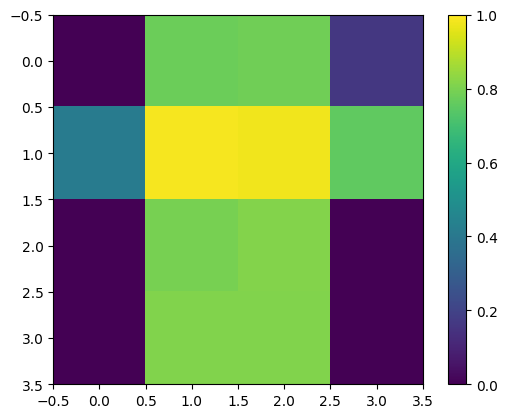

In [61]:
# resize the images
x_train_expanded = tf.expand_dims(x_train_filtered, axis=-1)
x_test_expanded = tf.expand_dims(x_test_filtered, axis=-1)

qnn_results_bilinear_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bilinear')

# Filtro Hat/Tent

0
Epoch 1/3
375/375 [==============================] - 420s 1s/step - loss: 0.6565 - hinge_accuracy: 0.6889 - val_loss: 0.4723 - val_hinge_accuracy: 0.7674
Epoch 2/3
375/375 [==============================] - 408s 1s/step - loss: 0.4745 - hinge_accuracy: 0.7675 - val_loss: 0.4548 - val_hinge_accuracy: 0.7773
Epoch 3/3
63/63 [==============================] - 4s 68ms/step - loss: 0.4497 - hinge_accuracy: 0.7842


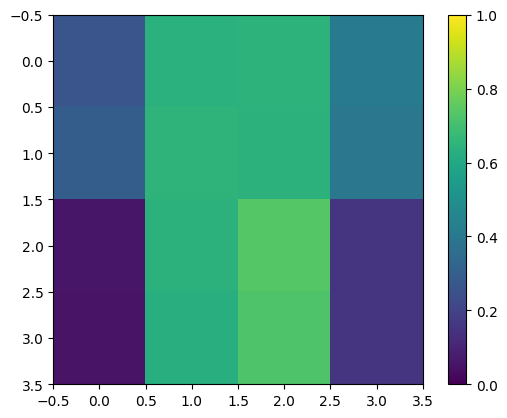

In [62]:
qnn_results_hat_tent_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bilinear', True)

## Filtro lanczos3

0
Epoch 1/3
375/375 [==============================] - 411s 1s/step - loss: 0.7285 - hinge_accuracy: 0.6620 - val_loss: 0.6441 - val_hinge_accuracy: 0.6880
Epoch 2/3
375/375 [==============================] - 412s 1s/step - loss: 0.5806 - hinge_accuracy: 0.7199 - val_loss: 0.6296 - val_hinge_accuracy: 0.6895
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.6258 - hinge_accuracy: 0.6875


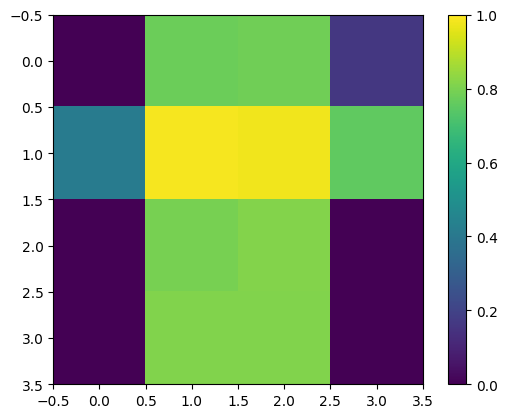

In [63]:
qnn_results_lanczos3_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'lanczos3')

## FIltro lanczos5

0
Epoch 1/3
375/375 [==============================] - 412s 1s/step - loss: 0.5723 - hinge_accuracy: 0.7142 - val_loss: 0.6223 - val_hinge_accuracy: 0.6910
Epoch 2/3
375/375 [==============================] - 411s 1s/step - loss: 0.5708 - hinge_accuracy: 0.7163 - val_loss: 0.6201 - val_hinge_accuracy: 0.6935
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.6182 - hinge_accuracy: 0.6930


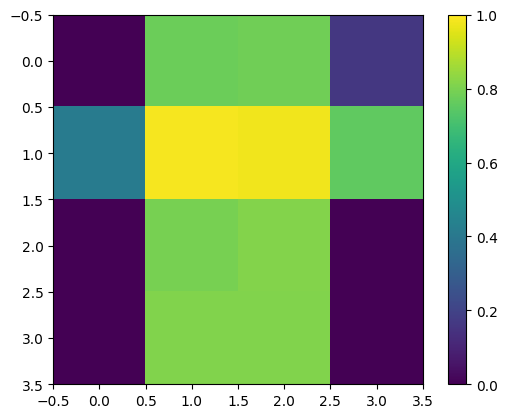

In [64]:
qnn_results_lanczos5_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'lanczos5')

## Filtro bicubic

0
Epoch 1/3
375/375 [==============================] - 412s 1s/step - loss: 0.5686 - hinge_accuracy: 0.7176 - val_loss: 0.6167 - val_hinge_accuracy: 0.6984
Epoch 2/3
375/375 [==============================] - 413s 1s/step - loss: 0.5679 - hinge_accuracy: 0.7216 - val_loss: 0.6161 - val_hinge_accuracy: 0.6984
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.6149 - hinge_accuracy: 0.6949


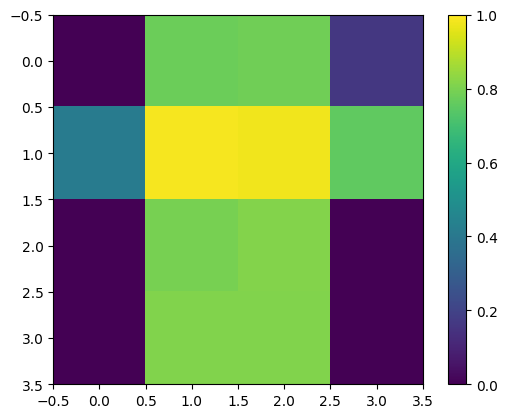

In [65]:
qnn_results_bicubic_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bicubic')

## Filtro gaussian

0
Epoch 1/3
375/375 [==============================] - 412s 1s/step - loss: 0.5844 - hinge_accuracy: 0.7100 - val_loss: 0.6384 - val_hinge_accuracy: 0.6825
Epoch 2/3
375/375 [==============================] - 412s 1s/step - loss: 0.5833 - hinge_accuracy: 0.7097 - val_loss: 0.6380 - val_hinge_accuracy: 0.6820
Epoch 3/3
63/63 [==============================] - 4s 68ms/step - loss: 0.6376 - hinge_accuracy: 0.6811


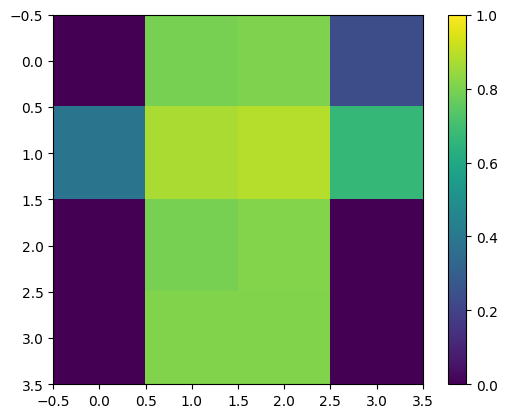

In [66]:
qnn_results_gaussian_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'gaussian')

## Filtro nearest

0
Epoch 1/3
375/375 [==============================] - 412s 1s/step - loss: 0.5652 - hinge_accuracy: 0.7177 - val_loss: 0.6120 - val_hinge_accuracy: 0.6939
Epoch 2/3
375/375 [==============================] - 412s 1s/step - loss: 0.5650 - hinge_accuracy: 0.7179 - val_loss: 0.6120 - val_hinge_accuracy: 0.6939
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.6126 - hinge_accuracy: 0.6939


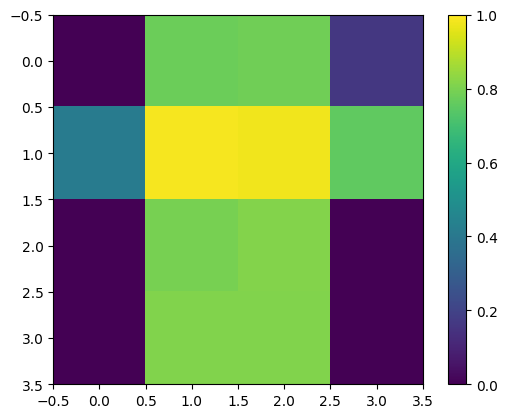

In [67]:
qnn_results_nearest_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'nearest')

## Filtro area

0
Epoch 1/3
375/375 [==============================] - 404s 1s/step - loss: 0.5362 - hinge_accuracy: 0.7452 - val_loss: 0.4227 - val_hinge_accuracy: 0.7966
Epoch 2/3
375/375 [==============================] - 403s 1s/step - loss: 0.4340 - hinge_accuracy: 0.7861 - val_loss: 0.4188 - val_hinge_accuracy: 0.7917
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.4119 - hinge_accuracy: 0.7981


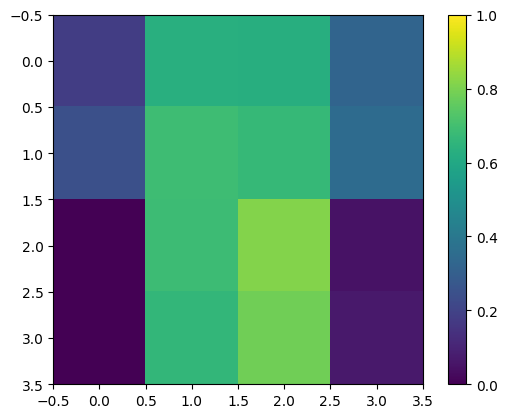

In [68]:
qnn_results_area_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'area')

## Filtro mitchellcubic

0
Epoch 1/3
375/375 [==============================] - 412s 1s/step - loss: 0.6575 - hinge_accuracy: 0.6927 - val_loss: 0.6295 - val_hinge_accuracy: 0.6974
Epoch 2/3
375/375 [==============================] - 411s 1s/step - loss: 0.5754 - hinge_accuracy: 0.7225 - val_loss: 0.6234 - val_hinge_accuracy: 0.6915
Epoch 3/3
63/63 [==============================] - 4s 69ms/step - loss: 0.6221 - hinge_accuracy: 0.6910


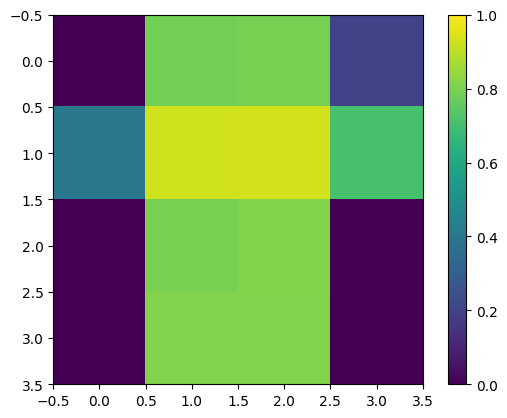

In [69]:
qnn_results_mitchellcubic_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'mitchellcubic')

## Comparação

/tmp/ipykernel_6169/3180368054.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


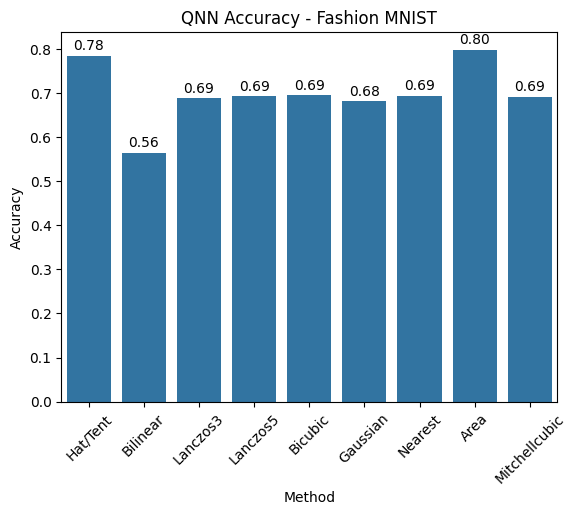

In [70]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_fashion[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_fashion[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_fashion[1]
qnn_accuracy_bicubic = qnn_results_bicubic_fashion[1]
qnn_accuracy_gaussian = qnn_results_gaussian_fashion[1]
qnn_accuracy_nearest = qnn_results_nearest_fashion[1]
qnn_accuracy_area = qnn_results_area_fashion[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_fashion[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - Fashion MNIST')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros - Cifar 100

2023-12-19 17:03:10.367445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Number of original training examples: 50000
Number of original test examples: 10000
Shape of x_train: (1000, 32, 32, 1)


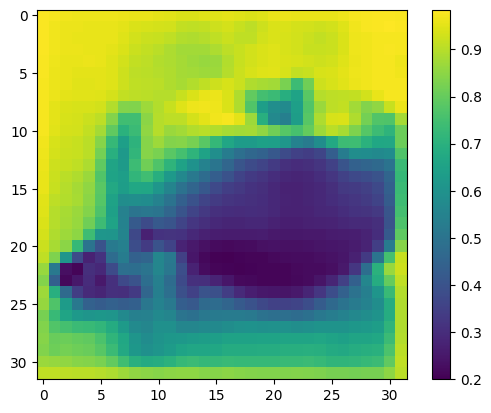

In [71]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

## Filtro de interpolação bilinear

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 1.0075 - hinge_accuracy: 0.4902 - val_loss: 1.0519 - val_hinge_accuracy: 0.4777
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.9867 - hinge_accuracy: 0.5049 - val_loss: 1.0107 - val_hinge_accuracy: 0.5000
Epoch 3/3
7/7 [==============================] - 1s 62ms/step - loss: 0.9289 - hinge_accuracy: 0.5268


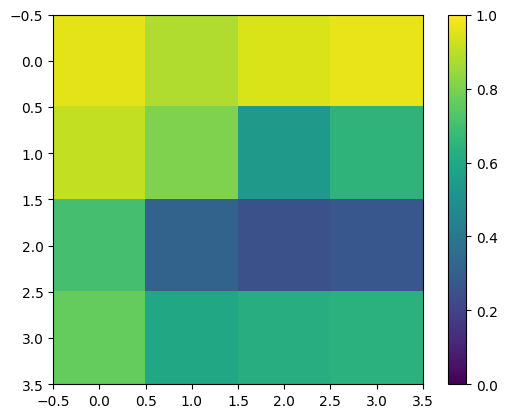

In [72]:
qnn_results_bilinear_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.9423 - hinge_accuracy: 0.5332 - val_loss: 0.9194 - val_hinge_accuracy: 0.5714
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8726 - hinge_accuracy: 0.5762 - val_loss: 0.8446 - val_hinge_accuracy: 0.6205
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.8335 - hinge_accuracy: 0.6339


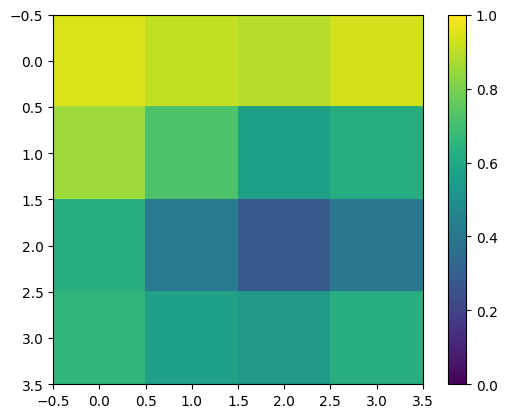

In [73]:
qnn_results_hat_tent_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8849 - hinge_accuracy: 0.5820 - val_loss: 0.8123 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8741 - hinge_accuracy: 0.5830 - val_loss: 0.7977 - val_hinge_accuracy: 0.6473
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7950 - hinge_accuracy: 0.6562


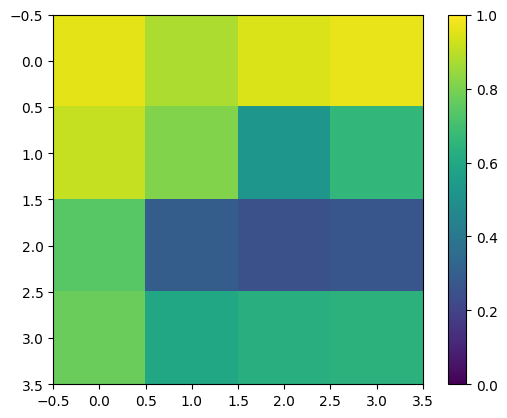

In [74]:
qnn_results_lanczos3_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8523 - hinge_accuracy: 0.5879 - val_loss: 0.7930 - val_hinge_accuracy: 0.6295
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8498 - hinge_accuracy: 0.5928 - val_loss: 0.7882 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7802 - hinge_accuracy: 0.6250


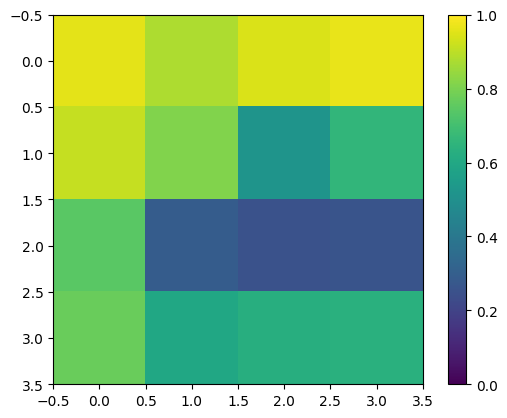

In [75]:
qnn_results_lanczos5_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8508 - hinge_accuracy: 0.5898 - val_loss: 0.7529 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8473 - hinge_accuracy: 0.5889 - val_loss: 0.7511 - val_hinge_accuracy: 0.6429
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7499 - hinge_accuracy: 0.6384


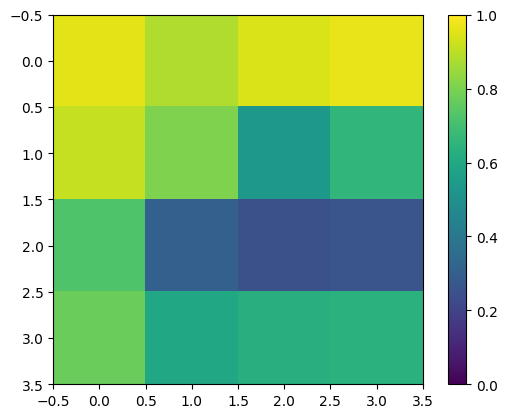

In [76]:
qnn_results_bicubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8394 - hinge_accuracy: 0.5947 - val_loss: 0.7607 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8359 - hinge_accuracy: 0.5986 - val_loss: 0.7581 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7589 - hinge_accuracy: 0.6295


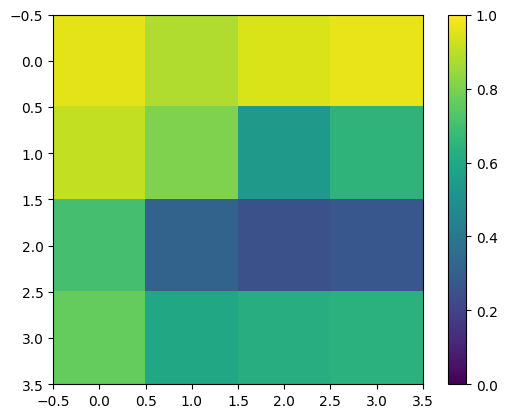

In [77]:
qnn_results_gaussian_cifar100 = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[0]
Epoch 1/3
32/32 [==============================] - 35s 1s/step - loss: 0.8595 - hinge_accuracy: 0.5869 - val_loss: 0.8000 - val_hinge_accuracy: 0.6027
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8513 - hinge_accuracy: 0.5928 - val_loss: 0.7964 - val_hinge_accuracy: 0.6071
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7913 - hinge_accuracy: 0.6071


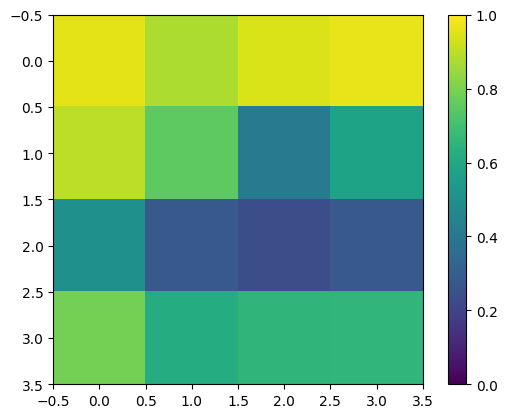

In [78]:
qnn_results_nearest_cifar100 = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8134 - hinge_accuracy: 0.6172 - val_loss: 0.7761 - val_hinge_accuracy: 0.6562
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8117 - hinge_accuracy: 0.6104 - val_loss: 0.7703 - val_hinge_accuracy: 0.6562
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7686 - hinge_accuracy: 0.6562


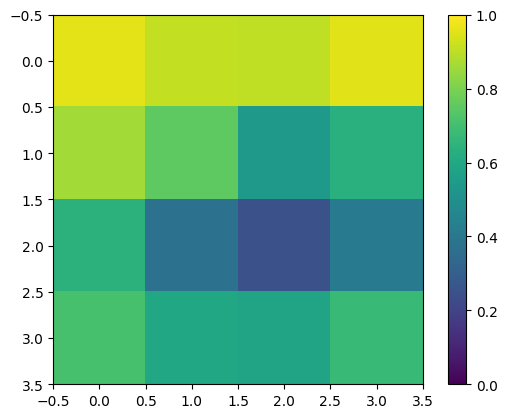

In [79]:
qnn_results_area_cifar100 = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8052 - hinge_accuracy: 0.6270 - val_loss: 0.7164 - val_hinge_accuracy: 0.6786
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.7973 - hinge_accuracy: 0.6250 - val_loss: 0.7120 - val_hinge_accuracy: 0.6786
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7150 - hinge_accuracy: 0.6741


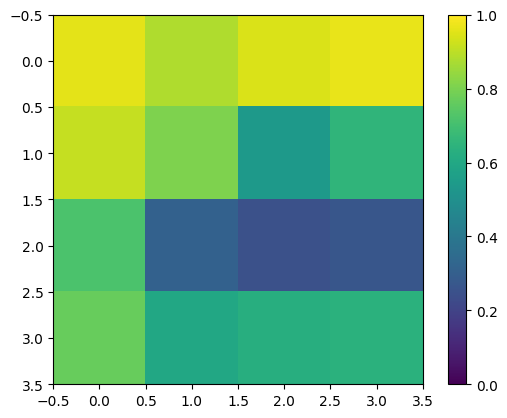

In [80]:
qnn_results_mitchellcubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6169/2989478445.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


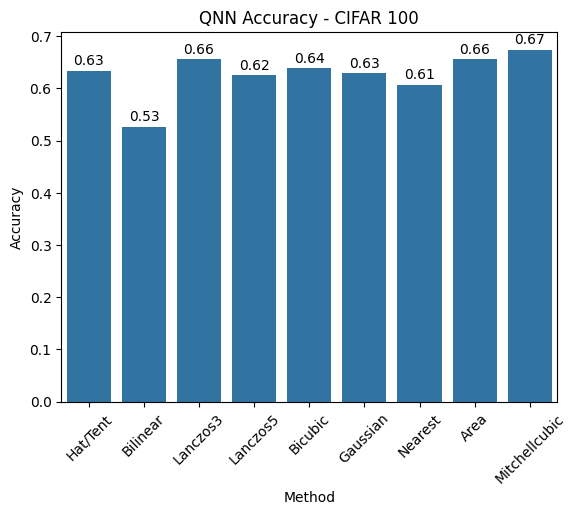

In [81]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar100[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar100[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar100[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar100[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar100[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar100[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar100[1]
qnn_accuracy_area = qnn_results_area_cifar100[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar100[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 100')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros - ImageNet

In [1]:
import tensorflow_datasets as tfds

# Carregar o conjunto de dados COCO
dataset_name = "coco/2017"
dataset = tfds.load(dataset_name, split=tfds.Split.TRAIN)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.coco.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

/home/henrique/Documentos/quantum/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-19 21:43:53.937311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-19 21:43:53.937341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-19 21:43:56.036774: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 100%|██████████| 7716625750/7716625750 [17:13<00:00, 19.24 MiB/s]

## Filtro de interpolação bilinear

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 1.0075 - hinge_accuracy: 0.4902 - val_loss: 1.0519 - val_hinge_accuracy: 0.4777
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.9867 - hinge_accuracy: 0.5049 - val_loss: 1.0107 - val_hinge_accuracy: 0.5000
Epoch 3/3
7/7 [==============================] - 1s 62ms/step - loss: 0.9289 - hinge_accuracy: 0.5268


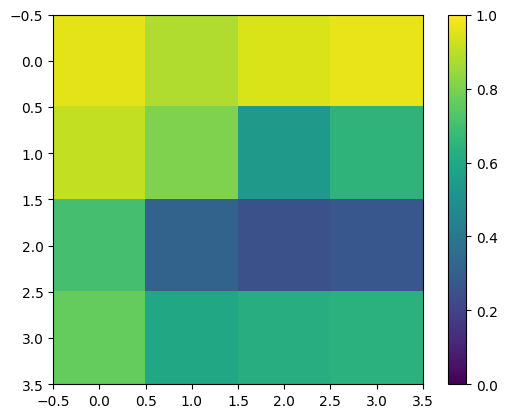

In [ ]:
qnn_results_bilinear_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.9423 - hinge_accuracy: 0.5332 - val_loss: 0.9194 - val_hinge_accuracy: 0.5714
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8726 - hinge_accuracy: 0.5762 - val_loss: 0.8446 - val_hinge_accuracy: 0.6205
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.8335 - hinge_accuracy: 0.6339


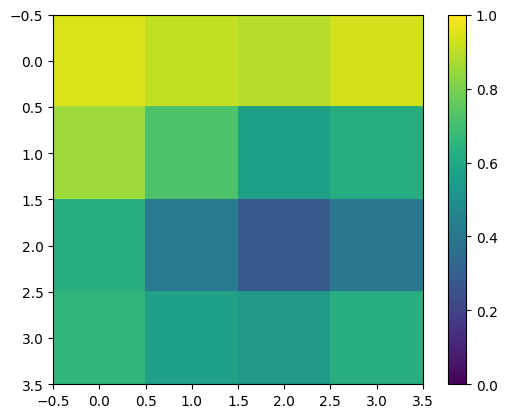

In [ ]:
qnn_results_hat_tent_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8849 - hinge_accuracy: 0.5820 - val_loss: 0.8123 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8741 - hinge_accuracy: 0.5830 - val_loss: 0.7977 - val_hinge_accuracy: 0.6473
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7950 - hinge_accuracy: 0.6562


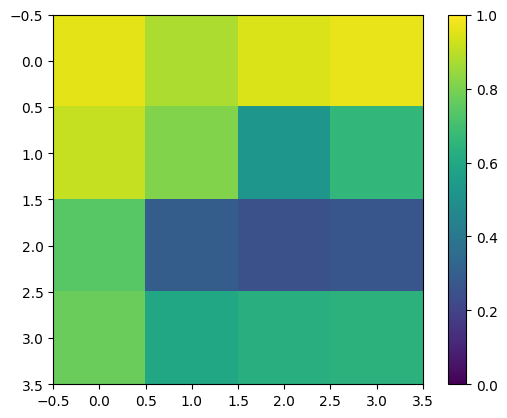

In [ ]:
qnn_results_lanczos3_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8523 - hinge_accuracy: 0.5879 - val_loss: 0.7930 - val_hinge_accuracy: 0.6295
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8498 - hinge_accuracy: 0.5928 - val_loss: 0.7882 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7802 - hinge_accuracy: 0.6250


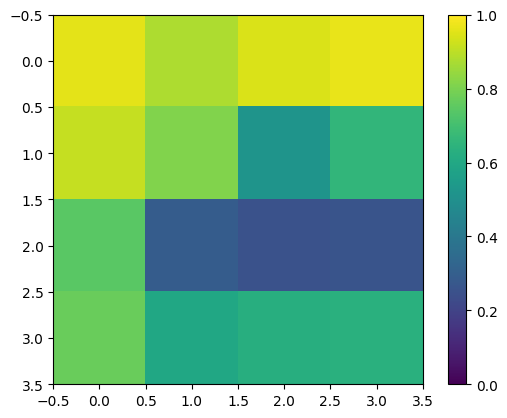

In [ ]:
qnn_results_lanczos5_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8508 - hinge_accuracy: 0.5898 - val_loss: 0.7529 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8473 - hinge_accuracy: 0.5889 - val_loss: 0.7511 - val_hinge_accuracy: 0.6429
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7499 - hinge_accuracy: 0.6384


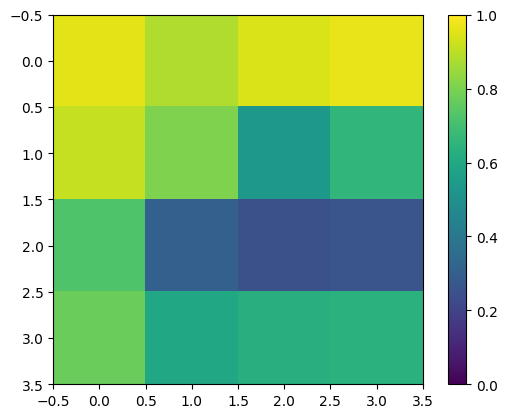

In [ ]:
qnn_results_bicubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8394 - hinge_accuracy: 0.5947 - val_loss: 0.7607 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8359 - hinge_accuracy: 0.5986 - val_loss: 0.7581 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7589 - hinge_accuracy: 0.6295


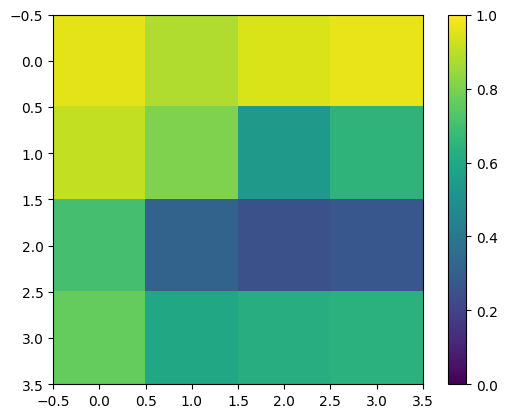

In [ ]:
qnn_results_gaussian_cifar100 = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[0]
Epoch 1/3
32/32 [==============================] - 35s 1s/step - loss: 0.8595 - hinge_accuracy: 0.5869 - val_loss: 0.8000 - val_hinge_accuracy: 0.6027
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8513 - hinge_accuracy: 0.5928 - val_loss: 0.7964 - val_hinge_accuracy: 0.6071
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7913 - hinge_accuracy: 0.6071


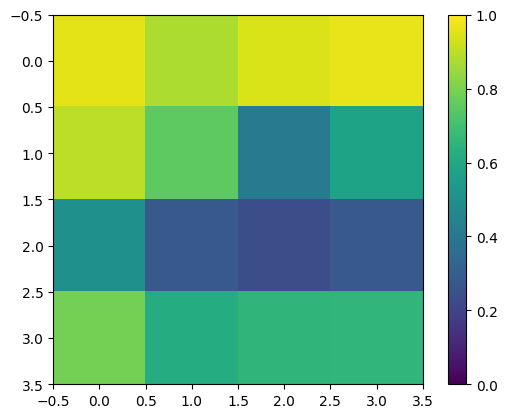

In [ ]:
qnn_results_nearest_cifar100 = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8134 - hinge_accuracy: 0.6172 - val_loss: 0.7761 - val_hinge_accuracy: 0.6562
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8117 - hinge_accuracy: 0.6104 - val_loss: 0.7703 - val_hinge_accuracy: 0.6562
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7686 - hinge_accuracy: 0.6562


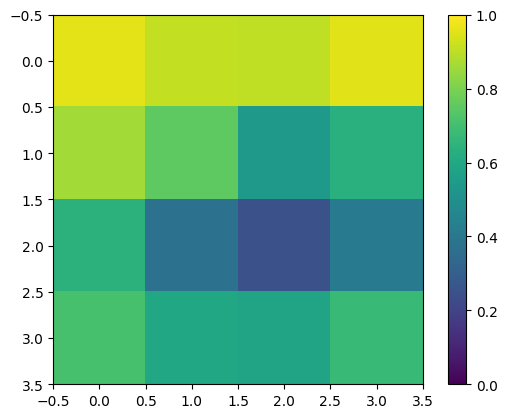

In [ ]:
qnn_results_area_cifar100 = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8052 - hinge_accuracy: 0.6270 - val_loss: 0.7164 - val_hinge_accuracy: 0.6786
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.7973 - hinge_accuracy: 0.6250 - val_loss: 0.7120 - val_hinge_accuracy: 0.6786
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7150 - hinge_accuracy: 0.6741


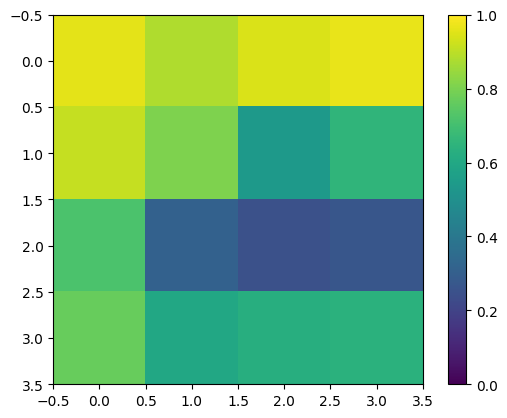

In [ ]:
qnn_results_mitchellcubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6169/2989478445.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


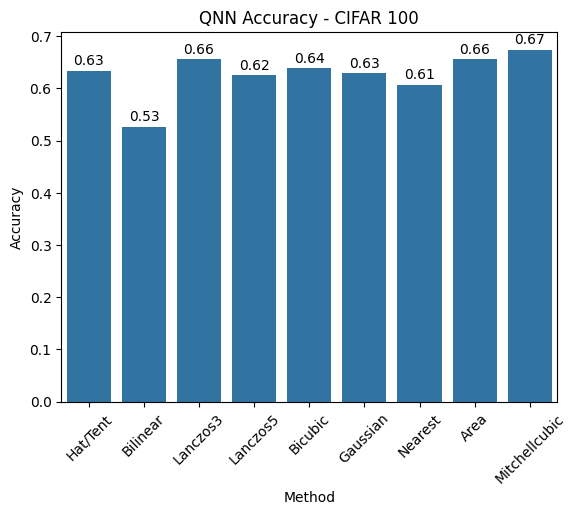

In [ ]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar100[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar100[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar100[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar100[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar100[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar100[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar100[1]
qnn_accuracy_area = qnn_results_area_cifar100[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar100[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 100')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()